# 1 . Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import spacy
import re
import warnings
import random
import seaborn as sns
import string

In [2]:
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

2023-11-25 14:14:16.312210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 14:14:17.276441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### First I load the datset and show 10 random samples of it

In [3]:
df = pd.read_csv("Data/twitter_training.csv")

In [5]:
df.sample(10)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
26465,946,AssassinsCreed,Positive,Wow .
2772,1682,CallOfDutyBlackopsColdWar,Positive,"Whoever buys me this shit, I'm ready to do any..."
63136,7622,MaddenNFL,Neutral,@SHUTDOWNSAFETY IN ANY CLINT OLDENBURG HIGHLIG...
32997,6462,Fortnite,Positive,″ Nothing screams the left and wing agenda lik...
17134,9736,PlayStation5(PS5),Irrelevant,Don’t read anything or all your family die
19265,12500,WorldOfCraft,Positive,This amazing trailer by @Blizzard_Ent shows al...
43073,10192,PlayerUnknownsBattlegrounds(PUBG),Negative,@PUBGMOBILE . @PUBG . Hello why pubg mobile a...
29963,752,ApexLegends,Irrelevant,Look at me everybody.. I'm a super dooper cool...
56010,11214,TomClancysRainbowSix,Neutral,Shout out to my brother @ CoconutBrah for prob...
8356,9433,Overwatch,Negative,forgot i always overwatch


In [6]:
print(f'The shape of the dataset is : {df.shape}')

The shape of the dataset is : (74681, 4)


In [7]:
print(f"The columns are: {df.columns}")

The columns are: Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')


In [10]:
print(f"The dtypes of the datset : \n\n{df.dtypes}")

The dtypes of the datset : 

2401                                                      int64
Borderlands                                              object
Positive                                                 object
im getting on borderlands and i will murder you all ,    object
dtype: object


#### Quick review of basic information

In [11]:
df.describe(include='all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


# 2. EDA

In [12]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = dataset.isnull().sum()/len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [13]:
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


In [14]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


#### Change name of columns

In [15]:
df.rename(columns={'2401':'Index','Borderlands':'Land','Positive':'Mode'
                   ,"im getting on borderlands and i will murder you all ,": 'Text'}, inplace=True)

In [16]:
df.columns

Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')

In [17]:
print(f'The number of unique lands : {len(df.Land.unique())}')
print('**' * 40)
df.Land.unique()

The number of unique lands : 32
********************************************************************************


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [18]:
lands = df.Land.value_counts()
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


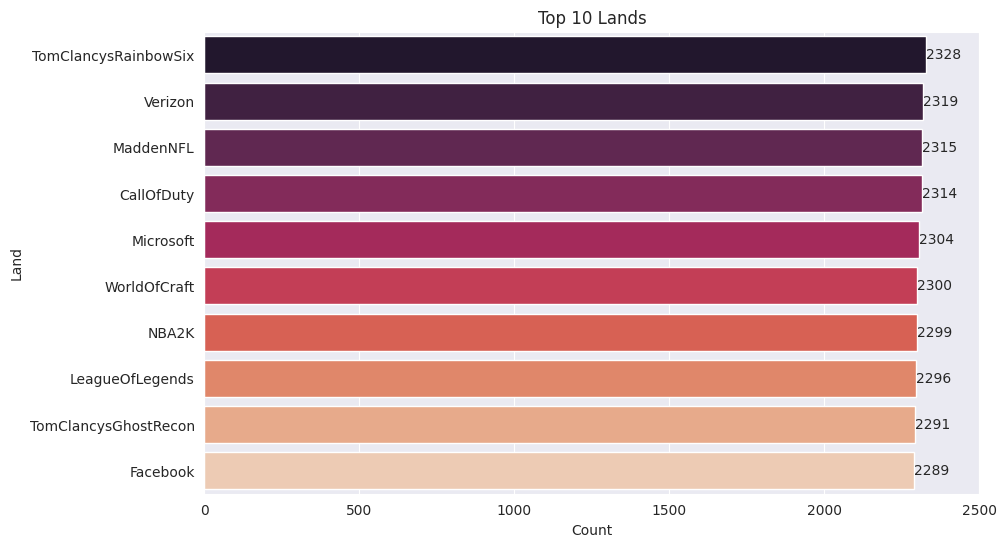

In [19]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10], y=lands.index[:10], palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

#### columns 'Mode' : Positive, Negative, Neutral, Irrelevent 

In [20]:
print(f'The unique values of Mode : {len(df.Mode.unique())}')
print('**' * 20)
print(df.Mode.unique())

The unique values of Mode : 4
****************************************
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [21]:
mode = df.Mode.value_counts()
mode.to_frame().T

Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19712,17708,12537


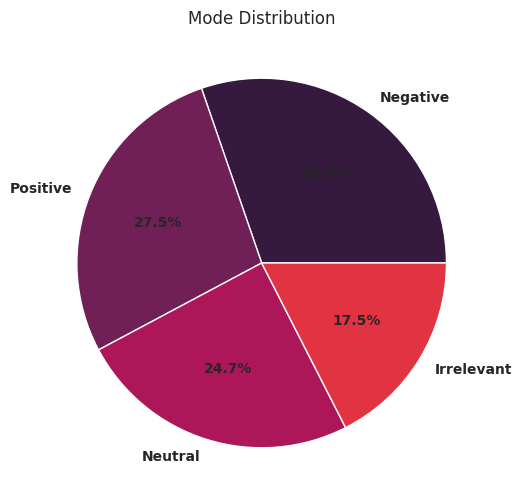

In [22]:
plt.figure(figsize=(6,6))
plt.pie(x=mode.values, labels=mode.keys(), autopct="%1.1f%%", textprops={"fontsize":10,"fontweight":"black"},
       colors=sns.color_palette("rocket"))
plt.title('Mode Distribution') 
plt.show()